# **Regression Analysis**

## **Imports and data loading**

In [1]:
# Packages for numerics + dataframes
import numpy as np
import pandas as pd

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Logistic Regression & Confusion Matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

In [2]:
# Load the dataset
df = pd.read_csv('../data/waze_dataset.csv')

> Based on previous EDA and data cleaning:
>
> * The `ID` variable is not needed for our analysis.
> * There are 700 `NA` values in the `label` column.
> * The data has 82% retained and 18% churned users.
> * `sessions`, `drives`, `total_sessions`, `total_navigations_fav_1`, `total_navigations_fav_2`, `driven_km_drives` and `duration_km_drives` have abnormally high maximum values, which is an indicator of outliers.
>   
>   
> **The goal is to build a machine learning model that identifies users at risk of leaving (churn), enabling Waze to engage them proactively with targeted retention strategies that enhance user satisfaction and drive business growth.**

In [3]:
df.drop('ID', axis = 1, inplace = True)

In [4]:
# Drop rows with missing data in `label` column
df.dropna(inplace = True)

In [5]:
# Impute outliers with 95 percentile data
cols = ['sessions', 'drives', 'total_sessions', 'driven_km_drives', 'duration_minutes_drives']
for col in cols:
    df[col] = df[col].clip(upper = df[col].quantile(0.95))

In [6]:
df['label'].value_counts(normalize = True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

## **Create new predictor variables**

#### **`km_per_driving_day`**

In [7]:
# 1. Convert infinite values to zero
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14299.000000
mean       567.010426
std        970.136935
min          0.000000
25%        136.168003
50%        273.301012
75%        543.473676
max       8898.716275
Name: km_per_driving_day, dtype: float64

#### **`professional_driver`**

> Create a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives **and** drove on 15+ days in the last month.
>
> The objective is to create a new feature that separates professional drivers from other drivers. 

In [8]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [9]:
# Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# Check in-class churn rate
print(df.groupby('professional_driver')['label'].value_counts(normalize = True))

professional_driver
0    11811
1     2488
Name: count, dtype: int64
professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64


The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%.

## **Binomial logistic regression assumptions**

1) Independent observations

2) No extreme outliers

3) Little to no multicollinearity among X predictors

4) Linear relationship between X and the **logit** of y

> * Assume that the observations are independent for this project.
> 
> * Extreme outliers have been identified and imputed in a previous step.
>
> * The linear relationship between the predictor variables (X) and the logit of the target (y) will be assessed after fitting the logistic regression model.
> 
> _In practice, modeling assumptions are often violated._

### **Prepare variables**

> Assign `0` to all retained users and `1` to all churned users.

In [10]:
# Create new binary `label2` column as to not overwrite original `label` variable
df['label2'] = np.where(df['label'] == 'retained', 0, 1)

> Assign `0` to `Android` users and `1` to `iPhone` users.

In [11]:
# Create new `device2` variable as to not overwrite original `device` variable
df['device2'] = OneHotEncoder(drop = 'first').fit_transform(df[['device']]).toarray()

### **Multicollinearity**

In [12]:
# Generate a correlation matrix
df.corr(method = 'pearson', numeric_only = True)

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2,device2
sessions,1.000000,0.996942,0.597189,0.007101,0.002982,0.004513,0.002996,-0.004545,0.025113,0.020294,-0.012540,0.443654,0.034911,0.012704
drives,0.996942,1.000000,0.595285,0.006940,0.002286,0.006165,0.003445,-0.003889,0.024357,0.019608,-0.011929,0.444425,0.035865,0.011684
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000863,0.007780,0.001016,-0.000338,0.015755,0.012953,-0.015717,0.254433,0.024568,0.012138
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.004536,-0.006433,-0.004652,-0.010167,-0.009418,-0.007321,0.011043,0.003770,-0.129263,-0.011299
total_navigations_fav1,0.002982,0.002286,0.000863,-0.004536,1.000000,0.003734,-0.006481,0.007306,0.010318,0.010024,0.000364,0.001257,0.055537,-0.000679
total_navigations_fav2,0.004513,0.006165,0.007780,-0.006433,0.003734,1.000000,0.004003,-0.004345,-0.004836,0.000938,0.008355,0.003535,0.020051,0.001079
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.006481,0.004003,1.000000,0.690515,-0.007441,-0.009549,0.334646,-0.000904,0.019767,-0.002091
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.007306,-0.004345,0.690515,1.000000,-0.007895,-0.009425,0.233281,-0.012128,0.040407,-0.007709
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010318,-0.004836,-0.007441,-0.007895,1.000000,0.947687,-0.414868,0.453825,-0.303851,-0.010221
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010024,0.000938,-0.009549,-0.009425,0.947687,1.000000,-0.424977,0.469776,-0.294259,-0.003859


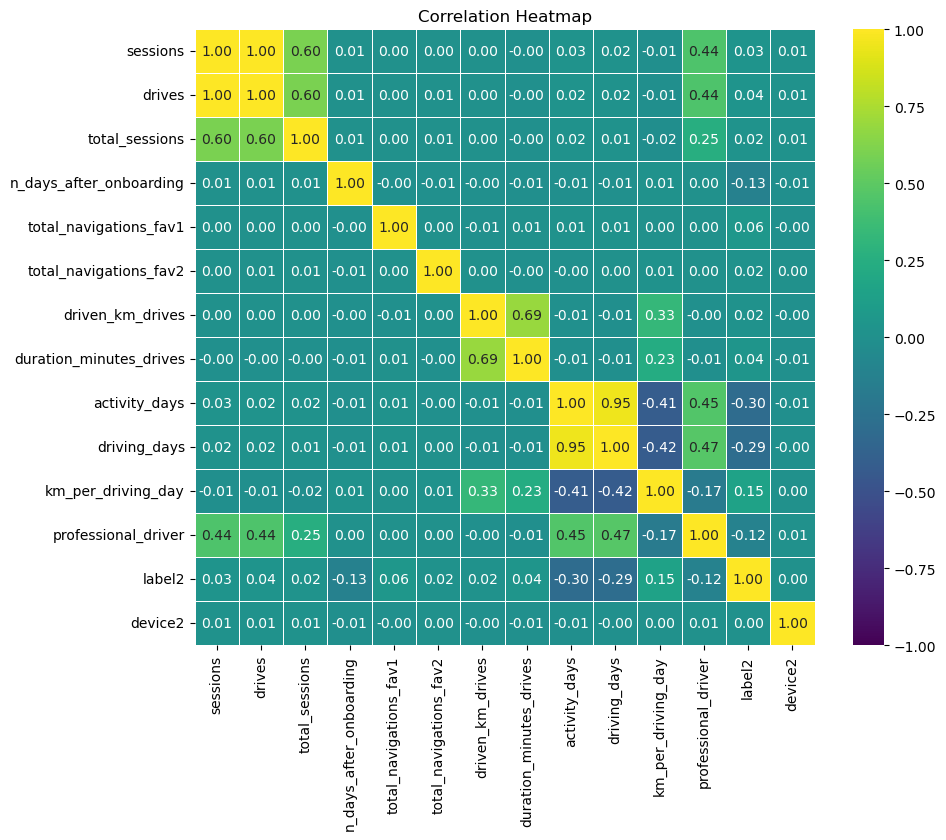

In [13]:
# Plot correlation heatmap
plt.figure(figsize = (10, 8)) 
sns.heatmap(df.corr(numeric_only = True), annot = True, cmap = 'viridis', fmt = '.2f', linewidths = 0.5, vmin = -1, vmax = 1)
plt.title("Correlation Heatmap")
plt.show()

Variable pairs with high multicollinearity (correlation ≥ 0.70):
* `drives` and `sessions`: 1.0
* `driving_days` and `activity_days`: 0.95

To decide which variable to drop in each pair, we compare their correlations with the target variable `label2`:
* `drives`: 0.04
* `sessions`: 0.03
* `driving_days`: -0.29
* `activity_days`: -0.30

Since `drives` and `activity_days` show stronger correlations with the target variable `label2`, we drop `sessions` and `driving_days` from the dataset. While a stronger correlation does not guarantee better predictive power, it generally indicates greater relevance to the target. This approach helps retain the most informative features while reducing multicollinearity.

## **Build logistic regression model**

### **Assign predictor variables and target**

Drop the following variables and assign the results to `X`:

* `label` (this is the target)
* `label2` (this is the target)
* `device` (this is the non-binary-encoded categorical variable)
* `sessions` (this had high multicollinearity)
* `driving_days` (this had high multicollinearity)

In [14]:
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

# Isolate target variable
y = df['label2']

### **Partition the data**

In [15]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, 
                                                    stratify = y) # preserve class proportions in split

### **Model training**

In [16]:
model = LogisticRegression(penalty = None, max_iter = 4000).fit(X_train, y_train)

In [17]:
pd.Series(model.coef_[0], index=X.columns)

drives                     0.001947
total_sessions             0.000363
n_days_after_onboarding   -0.000399
total_navigations_fav1     0.001073
total_navigations_fav2     0.001186
driven_km_drives          -0.000011
duration_minutes_drives    0.000110
activity_days             -0.105236
km_per_driving_day         0.000017
professional_driver       -0.013233
device2                    0.017016
dtype: float64

In [18]:
model.intercept_

array([-0.06010015])

### **Check final assumption**

In logistic regression, the relationship between a predictor variable and the dependent variable does not need to be linear, however, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. Here is the formula for calculating log-odds, where _p_ is the probability of response:
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$
<br>
> The train set is used to evaluate the linearity assumption in logistic regression because the model is fitted on the training data, and the assumption concerns how well the model structure (i.e., the linear relationship between the logit of predicted probabilities and continuous predictors) fits that data.

In [19]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)

# Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# Create a new `logit` column in the `logit_data` df
logit_data['logit'] = np.log(training_probabilities[:,1] / training_probabilities[:,0])
logit_data.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2,logit
152,108,186.192746,3116,243,126,8898.716275,4668.180092,24,593.247752,1,1.0,-2.716237
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,1.0,-0.522443
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,0.0,-1.177290
669,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1,1.0,-2.051467
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,1.0,-3.586707


In an exhaustive analysis, the regplot would be plotted for each continuous predictor variable. Here only `activity_days` and `total_sessions` are shown as examples.

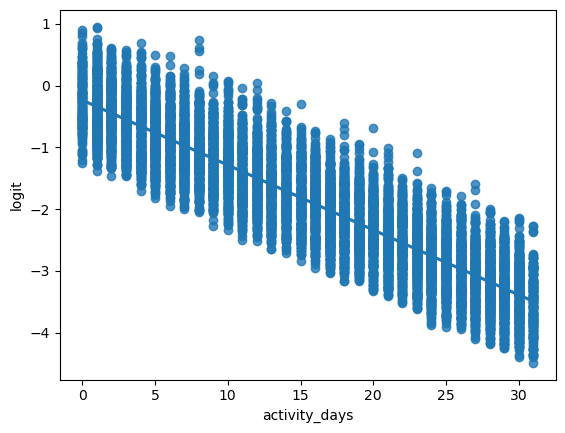

In [20]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x = 'activity_days',
            y = 'logit',
            data = logit_data);

There is a clear negative relationship between logit and `activity_days`.

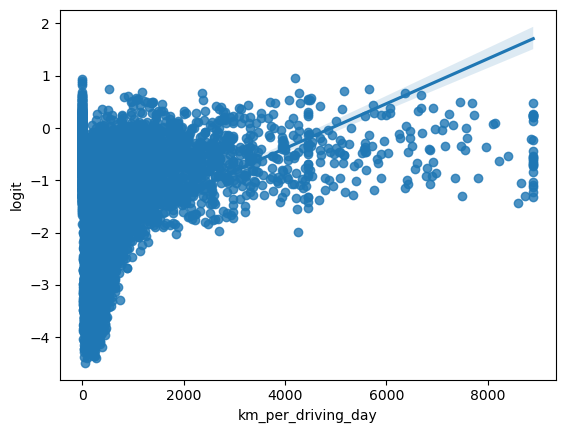

In [21]:
# Plot regplot of `km_per_driving_day` log-odds
sns.regplot(x = 'km_per_driving_day',
            y = 'logit',
            data = logit_data);

This lack of a clear linear relationship between the `logit` and `km_per_driving_day`, indicating a violation of the linearity assumption, is common and to be expected in real-world scenarios.

## **Results and evaluation**

In [22]:
# Generate predictions on X_test
y_pred = model.predict(X_test)

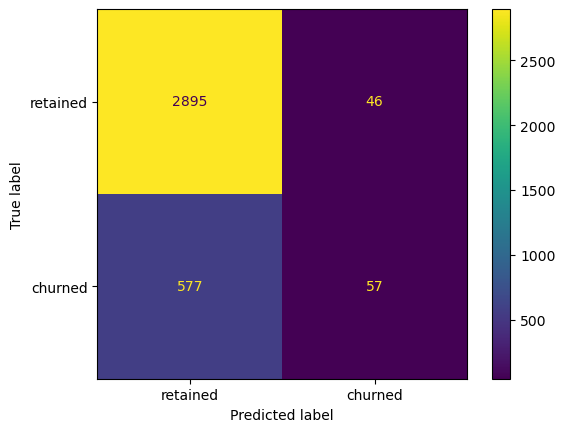

In [23]:
# Generate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels = model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['retained', 'churned'])
disp.plot(cmap = 'viridis');

In [24]:
# Create a classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      2941
           1       0.55      0.09      0.15       634

    accuracy                           0.83      3575
   macro avg       0.69      0.54      0.53      3575
weighted avg       0.78      0.83      0.77      3575



The fitted binomial logistic regression model demonstrates strong overall accuracy (83%) and excellent recall (98%) for the majority class (label 0). However, it performs poorly in identifying the minority class (label 1), with a low recall of 9% and an F1-score of only 0.15. This indicates the model struggles to correctly detect positive cases, resulting in many false negatives. The imbalance in class performance suggests the model is biased towards the majority class, limiting its effectiveness in applications where identifying the minority class accurately is critical.

### **Variable importance**

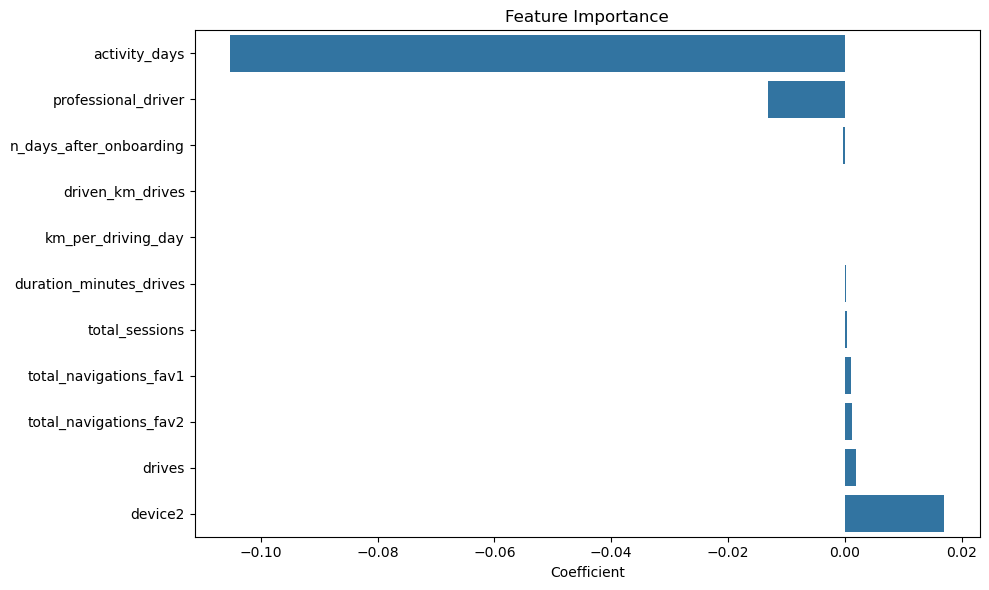

In [25]:
# Plot the feature importances
model_coef = pd.DataFrame(zip(X_test.columns, [float(c) for c in model.coef_[0]]),
                          columns = ['Feature', 'Coefficient'])
model_coef_sorted = model_coef.sort_values(by = 'Coefficient')
plt.figure(figsize = (10, 6))
sns.barplot(x = model_coef_sorted['Coefficient'], y = model_coef_sorted['Feature'], orient = 'h')
plt.ylabel('')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## **Data Insights**

* `activity_days` was the most influential predictor, evidenced by its largest coefficient magnitude. This aligns with the correlation heatmap, where it had the strongest negative correlation with `label2` (-0.30).
  
* Although `km_per_driving_day` and `n_days_after_onboarding` showed moderate correlations with `label2` (0.15 and -0.13, respectively), `professional_driver`, with a slightly lower correlation (-0.12), emerged as the second most important predictor in the feature importance plot.

* Before fitting the logistic regression model, variables exhibiting strong pairwise correlations were identified and removed using a correlation heatmap to reduce redundancy. Despite this, moderate multicollinearity persists among some remaining predictors. For example, `duration_minutes_drives` and `driven_km_drives` have a correlation of 0.69. This multicollinearity can affect the model’s ability to accurately estimate the individual impact of correlated variables, leading to coefficient magnitudes that may not fully represent their true contribution to the outcome.

* The classification report indicates that the model has poor recall for churned users, meaning it failed to identify many actual churn cases. Specifically, it misclassified 576 churned users as retained. Since the objective is to predict user churn accurately, low recall is problematic because it means the model is missing a large portion of users who are at risk of churning, reducing its usefulness for proactive retention strategies.

* The dataset is highly imbalanced, with 82.2% retained users and only 17.8% churned users. As a result, the logistic regression model tends to predict users as retained even when they have actually churned, leading to a high number of false negatives. While the `stratify` argument in `train_test_split` ensures that this imbalance is reflected proportionally in both training and test sets, it does not address the model’s bias during training. To mitigate this, the `class_weight` parameter in `LogisticRegression` can be used to assign greater importance to the minority class, encouraging the model to better detect churned users and improving recall. Additionally, since predictions are made using the default classification threshold of 0.5, performance can be further optimized by using a ROC curve to identify a more suitable threshold that balances recall and false positive rate.

* I would request access to the geographical locations of users' drives, specifically, the start (app open) and end (app close) points for each driving day. This information could offer valuable insights into regional usage patterns and how users in different areas engage with the service differently.